In [1]:
import os
import json
import time
import random 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mglearn
from scipy.spatial.distance import cdist
import gurobipy as gp
from gurobipy import GRB
from scipy.stats import skew
import math
import itertools
from sklearn.cluster import DBSCAN

# Load functions
from data_gen_functions import generate_tsp_instance, generate_cvrp_instance, fun_convert_time
from data_gen_functions import solve_tsp, solve_cvrp, plot_instance

In [2]:
# Function to visualize an instance and its optimal solution; additionally you can view cluster assignments of the corresponding model (DBSCAN)
def plot_instance(coord, sequence, total_costs, x_range, y_range, routing_problem, assignments=None, core_point_indices=None, plot_sequence=True, print_sequence=False):
    
    if (print_sequence == True): print('Total costs: {}\nOptimal solution: {}'.format(total_costs, sequence))

    # Depot_coord: tuple with depot X and Y coordinate
    depot_coord = coord[0]

    # Customer_coord: list of tuples with all customers X and Y coordinates; x_coord: list with X coordinates of customers; y_coord: list with Y coordinates of customers
    customer_coord = coord[1:]
    x_coord = np.array([i[0] for i in np.array(customer_coord)])
    y_coord = np.array([i[1] for i in np.array(customer_coord)])

    # Add optimal route with arrows between origin and destination in sequence
    if (plot_sequence == True) & (sequence is not None):

        # Get the number depot appearances in the sequence to count the routes and used vehicles (only relevant for CVRP)
        new_route_starts = np.where([trip[0] == 0 for trip in sequence])[0]
        num_routes = len(new_route_starts)
        colors = ['royalblue', 'coral', 'mediumseagreen', 'mediumorchid', 'sienna', 'dimgrey', 'crimson', 'silver', 'hotpink', 'darkcyan']

        # Mark each route of the used vehicles with arrows in another color (first extract the routes inside of the sequence)
        route_labels = []
        for index in range(num_routes):
            if (index != num_routes-1): route = sequence[new_route_starts[index] : new_route_starts[index+1]]
            if (index == num_routes-1): route = sequence[new_route_starts[index] :]

            # Set the color
            if (routing_problem == 'TSP'): color = 'silver'
            elif (routing_problem == 'CVRP'): color = colors[index % len(colors)] # Start with the first color again if there are more routes than colors

            # Add the route label for the legend
            route_label = f'Route {index + 1}'
            route_labels.append(route_label)
            
            for i, trip in enumerate(route):
                origin = trip[0]
                destination = trip[1]
                x = coord[origin][0]
                y = coord[origin][1]
                dx = coord[destination][0] - coord[origin][0]
                dy = coord[destination][1] - coord[origin][1]
                plt.arrow(x=x, y=y, dx=dx, dy=dy, head_width=1.5, head_length=1.75, 
                          fc=color, ec=color, length_includes_head=True, zorder=2, 
                          label=route_label if i == 0 else '')

    # Create scatter plot with depot (black) and customers (blue)
    plt.scatter(x=depot_coord[0], y=depot_coord[1], color='crimson', label='Depot', marker='*', s=250, zorder=4)
    if (assignments is None):
        plt.scatter(x=x_coord, y=y_coord, color='steelblue', label='Customers', marker='o' if routing_problem == 'TSP' else '.', s=50, zorder=3)
        cluster_labels = ['Customers']
    
    # Plot customers according to their cluster assignments if parameter 'assignments' is defined
    if (assignments is not None):

        # Plot customers according to their cluster assignments
        cluster_labels = ['Cluster ' + str(int(i)) for i in np.unique(assignments)]
        mglearn.discrete_scatter(x1=x_coord, x2=y_coord, y=assignments, markers='o', s=8, labels=cluster_labels)

        # DBSCAN: Mark core points in the plot if the parameter 'core_point_indices' is defined and there is at least one core point
        if (core_point_indices is not None) and (list(core_point_indices)):

            # Get indices of core points
            core_points_mask = np.zeros_like(assignments, dtype=bool) # Create list with same length as assignments containing only zero/False values
            core_points_mask[core_point_indices] = True # Set core point indices to one/True

            # Mark core points with a dot and add a label as clarification in the legend
            mglearn.discrete_scatter(x1=x_coord[core_points_mask], x2=y_coord[core_points_mask], y=assignments[core_points_mask], markers='.', s=5, c='k', labels=['Core Point'])
            core_points_label = ['Core Point']
    
    # Add annotations to identify the customers
    for i in range(len(customer_coord)):
        plt.annotate(text='C' + str(i+1), xy=(x_coord[i], y_coord[i]), textcoords='offset points', xytext=(0, 5), ha='center')

    if (routing_problem == 'TSP'): plt.title('Traveling Salesman Problem', size=16)
    elif (routing_problem == 'CVRP'): plt.title('Capacitated Vehicle Routing Problem', size=16)
    plt.xlabel('X', fontweight='bold')
    plt.ylabel('Y', fontweight='bold')
    plt.xticks(range(0, x_range[1] + 10, int(x_range[1]/10))) # Adjust x ticks dynamically to the given x_range
    plt.yticks(range(0, y_range[1] + 10, int(x_range[1]/10))) # Adjust y ticks dynamically to the given y_range
    plt.grid(True, zorder=0)
    
    # Get handles and labels from all scatter plots and create the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    
    # Sort handles (legend symbols) and labels (legend names) to ensure the order 'Depot', 'Customers' / 'Clusters', 'Core Point' 'Route 1/2/3...'
    depot_index = labels.index('Depot')
    if (assignments is None):
        customers_index = labels.index('Customers')
        handles = [handles[depot_index], handles[customers_index]] + [h for i, h in enumerate(handles) if i not in [depot_index, customers_index]]
    elif (core_point_indices is not None) and (list(core_point_indices)):
        customers_index = [labels.index(cluster) for cluster in cluster_labels]
        core_points_index = labels.index('Core Point')
        handles = [handles[depot_index]] + [handles[i] for i in customers_index] + [handles[core_points_index]] + [h for i, h in enumerate(handles) if i not in [depot_index, customers_index, core_points_index]]
    else:
        customers_index = [labels.index(cluster) for cluster in cluster_labels]
        handles = [handles[depot_index]] + [handles[i] for i in customers_index] + [h for i, h in enumerate(handles) if i not in [depot_index, customers_index]]
    
    # Get unique labels and set legend labels dynamically
    legend_labels = ['Depot'] + cluster_labels
    if (core_point_indices is not None) and (list(core_point_indices)): legend_labels += core_points_label
    if ('route_labels' in locals()): legend_labels += route_labels # Check wheater route_labels is defined

    plt.legend(handles, legend_labels, loc='best', bbox_to_anchor=(1.05, 1.0))
    plt.show()

# **Gurobi solver**

Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-04
Total costs: 300.3497892813049
Optimal solution: [(0, 2), (2, 0), (0, 4), (4, 5), (5, 3), (3, 1), (1, 6), (6, 0)]


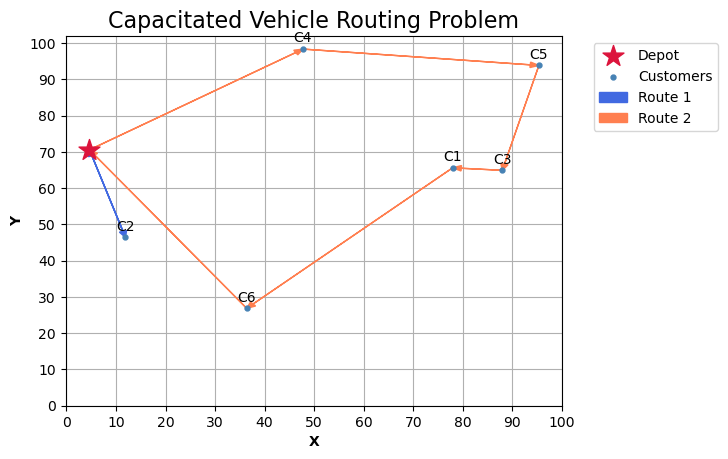

In [3]:
# Settings
num_customers = 6
x_range = (0, 100)
y_range = (0, 100)

routing_problem = 'CVRP'

if (routing_problem == 'TSP'):
    # Generate instance and extract the X and Y coordinates of depot and all customers
    instance_df = generate_tsp_instance(num_customers, x_range, y_range)
    coord = [(instance_df['X'][i], instance_df['Y'][i]) for i in range(len(instance_df))]

    # Solve TSP and receive sequence (optimal tour) and total costs as output
    sequence, total_costs = solve_tsp(coordinates=coord)

elif (routing_problem == 'CVRP'):
    capacity_min = 10
    capacity_max = 18
    demand_min = 1
    demand_max = 5

    # Generate instance and extract the X and Y coordinates of depot and all customers as well as the demands and the capacity
    instance_df = generate_cvrp_instance(num_customers, x_range, y_range, demand_min, demand_max, capacity_min, capacity_max)
    coord = [(instance_df['X'][i], instance_df['Y'][i]) for i in range(len(instance_df))]
    demands = list(instance_df['Demand'])
    capacity = list(instance_df['Vehicle Capacity'])[0]

    # Solve TSP and receive sequence (optimal tour) and total costs as output
    sequence, total_costs = solve_cvrp(coordinates=coord, demands=demands, capacity=capacity)

# Plot TSP with optimal tour
plot_instance(coord=coord, sequence=sequence, total_costs=total_costs, x_range=x_range, y_range=y_range, 
              assignments=None, core_point_indices=None, plot_sequence=True, print_sequence=True, routing_problem=routing_problem)

# **PyVRP Solver**

Exact Total costs: 4724.013954247142 and Rounded Total Costs: 4715
Optimal solution: [(0, 10), (10, 16), (16, 14), (14, 9), (9, 0), (0, 7), (7, 3), (3, 4), (4, 1), (1, 0), (0, 12), (12, 11), (11, 15), (15, 13), (13, 0), (0, 5), (5, 2), (2, 6), (6, 8), (8, 0)]


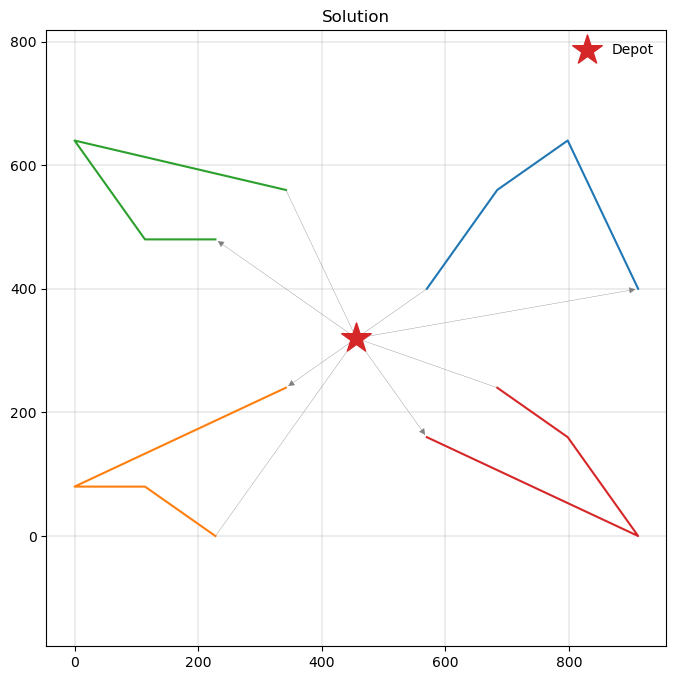

In [4]:
from tqdm import tqdm
import math
from tabulate import tabulate
from pyvrp import Model
import matplotlib.pyplot as plt
from pyvrp.plotting import plot_coordinates
from pyvrp.plotting import plot_solution
from pyvrp.stop import MaxRuntime

# Define coordinates and demands
coord = [
(456, 320),  # location 0 - the depot
(228, 0),    # location 1
(912, 0),    # location 2
(0, 80),     # location 3
(114, 80),   # location 4
(570, 160),  # location 5
(798, 160),  # location 6
(342, 240),  # location 7
(684, 240),  # location 8
(570, 400),  # location 9
(912, 400),  # location 10
(114, 480),  # location 11
(228, 480),  # location 12
(342, 560),  # location 13
(684, 560),  # location 14
(0, 640),    # location 15
(798, 640),  # location 16
]
demands = [0, 1, 1, 2, 4, 2, 4, 8, 8, 1, 2, 1, 2, 4, 4, 8, 8]

def solve_PyVRP(coord, demands, capacity, max_runtime=1, plot_results=False, prints=False):
    # Create the model and define the number of vehicles
    m = Model()
    num_vehicles = math.ceil(np.sum(demands) / capacity) + 1

    # Add vehicles, the depot and the customers to the model
    m.add_vehicle_type(num_available=num_vehicles, capacity=capacity)
    depot = m.add_depot(x=coord[0][0], y=coord[0][1])
    clients = [m.add_client(x=coord[idx][0], y=coord[idx][1], delivery=demands[idx]) for idx in range(1, len(coord))]

    # Add the distances/edges between all the locations (depot and customers)
    locations = [depot] + clients
    for frm in locations:
        for to in locations:
            distance = np.sqrt((frm.x - to.x)**2 + (frm.y - to.y)**2) # Euclidean
            m.add_edge(frm, to, distance=distance)

    # Plot instance
    if (prints == True):
        _, ax = plt.subplots(figsize=(8, 8))
        plot_coordinates(m.data(), ax=ax)

    # Solve instance
    res = m.solve(stop=MaxRuntime(max_runtime), display=prints) # Define maximum run time (in seconds) for solving the instance
    
    # Get informations about the routes within the best solution and the rounded total costs of the best solution
    routes_details = res.best.routes()
    total_costs_rounded = res.cost()

    data = [{'Number of Stops': len(route),
            'Customers': route.visits(),
            'Distance': route.distance(),
            'Delivery (Sum of Demands)': route.delivery()}
            for route in routes_details]

    # Display the information about the routes
    header = list(data[0].keys())
    rows = [datum.values() for datum in data]
    if (prints == True): display(tabulate(rows, header, tablefmt='html'))

    # Add the depot as start and end point to each route and convert it to the same format as the output of the Gurobi functions
    routes = [[0] + route['Customers'] + [0] for route in data] # e.g. routes = [[0, 2, 0], [0, 4, 3, 5, 1, 0]]
    sequence = [(route[trip], route[trip+1]) for route in routes for trip in range(len(route)-1)] # e.g. sequence = [(0, 2), (2, 0), (0, 4), (4, 3), (3, 5), (5, 1), (1, 0)]
    
    # Compute the customer distances matrix (including the depot)
    customer_distances = cdist(coord, coord, metric='euclidean')

    # Recompute total costs of best route
    total_costs = np.sum([customer_distances[trip[0], trip[1]] for trip in sequence])

    # Plot solution
    if (plot_results == True):
        print('Exact Total costs: {} and Rounded Total Costs: {}\nOptimal solution: {}'.format(total_costs, total_costs_rounded, sequence))
        _, ax = plt.subplots(figsize=(8, 8))
        plot_solution(res.best, m.data(), ax=ax)

    return sequence, total_costs

# Execute function
sequence, total_costs = solve_PyVRP(coord=coord, demands=demands, capacity=15, max_runtime=1, 
                                    plot_results=True, prints=False)

# **Comparison between Gurobi and PyVRP Solver**
### **TSP**

In [5]:
# Settings
num_customers_list = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] # All possible instance sizes (number of customers for an instance)
number_of_instances_per_size = 10 # Determines the number of instances that are generated for each instance size (number of customers)
iterations = [(size, id) for id in np.arange(1, number_of_instances_per_size+1) for size in num_customers_list]
x_range = (0, 100)
y_range = (0, 100)

# Create dictionaries to store the results
res_gurobi = {size: {'Total Costs': [], 'Run Times': []} 
               for size in num_customers_list}
all_instances = pd.DataFrame()

# Only create new instances (all_instances) and recompute res_gurobi if necessary
if False:
    for num_customers, id in tqdm(iterations):
        # Generate instance and extract the X and Y coordinates of depot and all customers
        instance_df = generate_tsp_instance(num_customers, x_range, y_range)
        coord = [(instance_df['X'][i], instance_df['Y'][i]) for i in range(len(instance_df))]

        # Solve instance with Gurobi and plot the optimal solution
        start = time.time()
        sequence, total_costs = solve_tsp(coordinates=coord)
        runtime = time.time() - start
        res_gurobi[num_customers]['Total Costs'] += [np.round(total_costs, 4)]
        res_gurobi[num_customers]['Run Times'] += [runtime]

        # Save instance
        instance_df['Instance ID'] = num_customers * 1000 + id
        all_instances = pd.concat([all_instances, instance_df])

    # Save all instances and the dictionary 'res_gurobi'
    all_instances.to_excel('tsp_instances.xlsx')

    with open('tsp_res_gurobi', 'w') as file:
        json.dump(res_gurobi, file)

In [6]:
# Create dictionaries to store the results
res_PyVRP = {str(size): {'Total Costs': [], 'Run Times': []} 
             for size in num_customers_list}
instances_dev = []

# Load instances and the results of the gurobi solver
all_instances = pd.read_excel('tsp_instances.xlsx')
with open('tsp_res_gurobi', 'r') as file:
    res_gurobi = json.load(file)

for id in tqdm(np.unique(all_instances['Instance ID'])):
    # Generate instance and extract the X and Y coordinates of depot and all customers
    instance_df = all_instances[all_instances['Instance ID'] == id].reset_index(drop=True)
    coord = [(instance_df['X'][i], instance_df['Y'][i]) for i in range(len(instance_df))]
    num_customers = len(instance_df) - 1 # First row is the depot

    # Solve instance with PyVRP and plot the optimal solution
    start = time.time()
    demands = [0] + list(np.repeat(1, num_customers))
    sequence, total_costs = solve_PyVRP(coord=coord, demands=demands, capacity=num_customers, max_runtime=0.001, 
                                        plot_results=False, prints=False)
    runtime = time.time() - start
    res_PyVRP[str(num_customers)]['Total Costs'] += [np.round(total_costs, 4)]
    res_PyVRP[str(num_customers)]['Run Times'] += [runtime]

    # Check wheater the solutions are the same
    test = (np.round(total_costs, 4) == np.round(total_costs, 4))
    if (test == False): instances_dev.append({'Instance DF': instance_df, 'Coordinates': coord, 'Demands': demands, 'Capacity': capacity, 
                                          'Total Costs Gurobi': total_costs, 'Sequence Gurobi': sequence, 'Run Time Gurobi': runtime,
                                          'Total Costs PyVRP': total_costs, 'Sequence PyVRP': sequence, 'Run Time PyVRP': runtime})

100%|██████████| 110/110 [00:00<00:00, 320.03it/s]


Mean Run Time of Gurobi Solver: 1.8634 sec 
Mean Run Time of PyVRP Solver: 0.0018 sec

Proportion of optimal solutions by PyVRP: 88.18 %


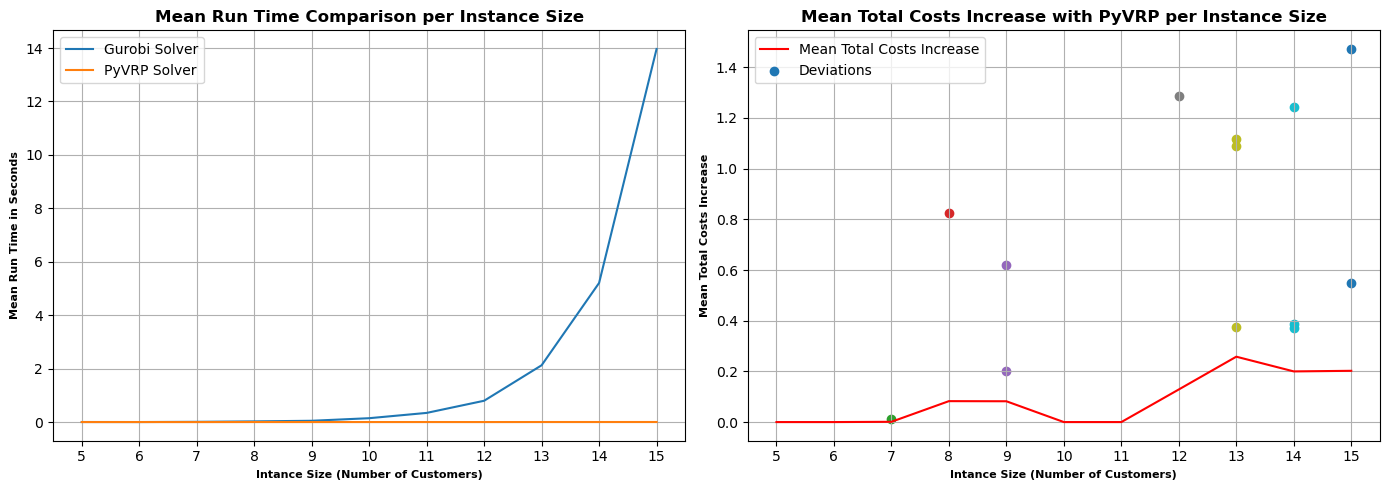

In [7]:
# Get mean run time of both solvers
mean_runtime_gurobi = np.mean([res_gurobi[key]['Run Times'][0] for key in res_gurobi.keys()])
mean_runtime_PyVRP= np.mean([res_PyVRP[key]['Run Times'][0] for key in res_PyVRP.keys()])
print('Mean Run Time of Gurobi Solver: {} sec \nMean Run Time of PyVRP Solver: {} sec'.format(np.round(mean_runtime_gurobi, 4), np.round(mean_runtime_PyVRP, 4)))

# Get all total costs
total_costs_gurobi = [res_gurobi[key]['Total Costs'] for key in res_gurobi.keys()]
total_costs_PyVRP = [res_PyVRP[key]['Total Costs'] for key in res_PyVRP.keys()]

# Compute the proportion of identical solutions
num_identical_solutions = 0
for index in range(len(num_customers_list)):
    num_identical_solutions += np.sum([i == j for i, j in zip(total_costs_gurobi[index], total_costs_PyVRP[index])])
pct_identical_solutions = np.round(num_identical_solutions / len(iterations), 4) * 100
print('\nProportion of optimal solutions by PyVRP: {} %'.format(pct_identical_solutions))

# Get mean run time for all instance sizes of both solvers
mean_cat_runtime_gurobi = {key: np.round(np.mean(res_gurobi[key]['Run Times']),4) for key in res_gurobi.keys()}
mean_cat_runtime_PyVRP = {key: np.round(np.mean(res_PyVRP[key]['Run Times']), 4) for key in res_PyVRP.keys()}

# Get all total costs per instance size of both solvers
cat_costs_gurobi = {key: res_gurobi[key]['Total Costs'] for key in res_gurobi.keys()}
cat_costs_PyVRP = {key: res_PyVRP[key]['Total Costs'] for key in res_PyVRP.keys()}
cat_costs_differences = {}
deviations = {}

# Compute the deviations of all total costs and the mean per instance size
for key in res_gurobi.keys():
    differences = [cat_costs_PyVRP[key][i] - cat_costs_gurobi[key][i] for i in range(number_of_instances_per_size)]
    cat_costs_differences[key] = np.mean(differences)
    deviations[key] = [i for i in differences if i > 0]

# Create subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# Plot mean run times per instance size
axs[0].plot(mean_cat_runtime_gurobi.values(), label='Gurobi Solver')
axs[0].plot(mean_cat_runtime_PyVRP.values(), label='PyVRP Solver')
axs[0].set_xticks(ticks=range(len(mean_cat_runtime_gurobi.keys())), labels=mean_cat_runtime_gurobi.keys())
axs[0].set_xlabel('Intance Size (Number of Customers)', size=8, fontweight='bold')
axs[0].set_ylabel('Mean Run Time in Seconds', size=8, fontweight='bold')
axs[0].set_title('Mean Run Time Comparison per Instance Size', size=12, fontweight='bold')
axs[0].grid(axis='both')
axs[0].legend()

# Plot mean total costs deviation per instance size
axs[1].plot(cat_costs_differences.keys(), cat_costs_differences.values(), color='r', label='Mean Total Costs Increase')
for key in deviations.keys():
    axs[1].scatter(x=np.repeat(key, len(deviations[key])), y=deviations[key], label='Deviations' if key == list(cat_costs_differences.keys())[0] else "")
axs[1].set_xticks(list(mean_cat_runtime_gurobi.keys()))
axs[1].set_xticklabels(cat_costs_differences.keys())
axs[1].set_xlabel('Intance Size (Number of Customers)', size=8, fontweight='bold')
axs[1].set_ylabel('Mean Total Costs Increase', size=8, fontweight='bold')
axs[1].set_title('Mean Total Costs Increase with PyVRP per Instance Size', size=12, fontweight='bold')
axs[1].grid(axis='both')
axs[1].legend()
plt.tight_layout()
plt.show()

### **CVRP**

In [8]:
# Settings
num_customers_list = [5, 6, 7, 8, 9, 10, 11, 12] # All possible instance sizes (number of customers for an instance)
number_of_instances_per_size = 10 # Determines the number of instances that are generated for each instance size (number of customers)
iterations = [(size, id) for id in np.arange(1, number_of_instances_per_size+1) for size in num_customers_list]
x_range = (0, 100)
y_range = (0, 100)
capacity_min = 10
capacity_max = 18
demand_min = 1
demand_max = 5

# Create dictionaries to store the results
res_gurobi = {size: {'Total Costs': [], 'Run Times': []} 
               for size in num_customers_list}
all_instances = pd.DataFrame()

# Only create new instances (all_instances) and recompute res_gurobi if necessary
if True:
    for num_customers, id in tqdm(iterations):
        # Generate instance and extract the X and Y coordinates of depot and all customers as well as the demands and the capacity
        instance_df = generate_cvrp_instance(num_customers, x_range, y_range, demand_min, demand_max, capacity_min, capacity_max)
        coord = [(instance_df['X'][i], instance_df['Y'][i]) for i in range(len(instance_df))]
        demands = list(instance_df['Demand'])
        capacity = list(instance_df['Vehicle Capacity'])[0]

        # Solve instance with Gurobi and plot the optimal solution
        start = time.time()
        sequence, total_costs = solve_cvrp(coordinates=coord, demands=demands, capacity=capacity)
        runtime = time.time() - start
        res_gurobi[num_customers]['Total Costs'] += [np.round(total_costs, 4)]
        res_gurobi[num_customers]['Run Times'] += [runtime]

        # Save instance
        instance_df['Instance ID'] = num_customers * 1000 + id
        all_instances = pd.concat([all_instances, instance_df])

    # Save all instances and the dictionary 'res_gurobi'
    all_instances.to_excel('cvrp_instances.xlsx')

    with open('cvrp_res_gurobi', 'w') as file:
        json.dump(res_gurobi, file)

100%|██████████| 80/80 [02:38<00:00,  1.99s/it]


In [12]:
# Create dictionaries to store the results
res_PyVRP = {str(size): {'Total Costs': [], 'Run Times': []} 
             for size in num_customers_list}
instances_dev = []

# Load instances and the results of the gurobi solver
all_instances = pd.read_excel('cvrp_instances.xlsx')
with open('cvrp_res_gurobi', 'r') as file:
    res_gurobi = json.load(file)

for id in tqdm(np.unique(all_instances['Instance ID'])):
    # Generate instance and extract the X and Y coordinates of depot and all customers
    instance_df = all_instances[all_instances['Instance ID'] == id].reset_index(drop=True)
    coord = [(instance_df['X'][i], instance_df['Y'][i]) for i in range(len(instance_df))]
    num_customers = len(instance_df) - 1 # First row is the depot

    # Solve instance with PyVRP and plot the optimal solution
    demands = [0] + list(np.repeat(1, num_customers))
    sequence, total_costs = solve_PyVRP(coord=coord, demands=demands, capacity=num_customers, max_runtime=0.001, 
                                        plot_results=False, prints=False)

    # Solve instance with PyVRP and plot the optimal solution
    start = time.time()
    demands = instance_df['Demand']
    capacity = instance_df.loc[0, 'Vehicle Capacity']
    sequence, total_costs = solve_PyVRP(coord=coord, demands=demands, capacity=capacity, max_runtime=1, 
                                        plot_results=False, prints=False)
    runtime = time.time() - start
    res_PyVRP[str(num_customers)]['Total Costs'] += [np.round(total_costs, 4)]
    res_PyVRP[str(num_customers)]['Run Times'] += [runtime]

    # Check wheater the solutions are the same
    test = (np.round(total_costs, 4) == np.round(total_costs, 4))
    if (test == False): instances_dev.append({'Instance DF': instance_df, 'Coordinates': coord, 'Demands': demands, 'Capacity': capacity, 
                                            'Total Costs Gurobi': total_costs, 'Sequence Gurobi': sequence, 'Run Time Gurobi': runtime,
                                            'Total Costs PyVRP': total_costs, 'Sequence PyVRP': sequence, 'Run Time PyVRP': runtime})

 66%|██████▋   | 53/80 [00:53<00:27,  1.01s/it]

Mean Run Time of Gurobi Solver: 0.8891 sec 
Mean Run Time of PyVRP Solver: 0.1025 sec

Proportion of optimal solutions by PyVRP: 88.75 %


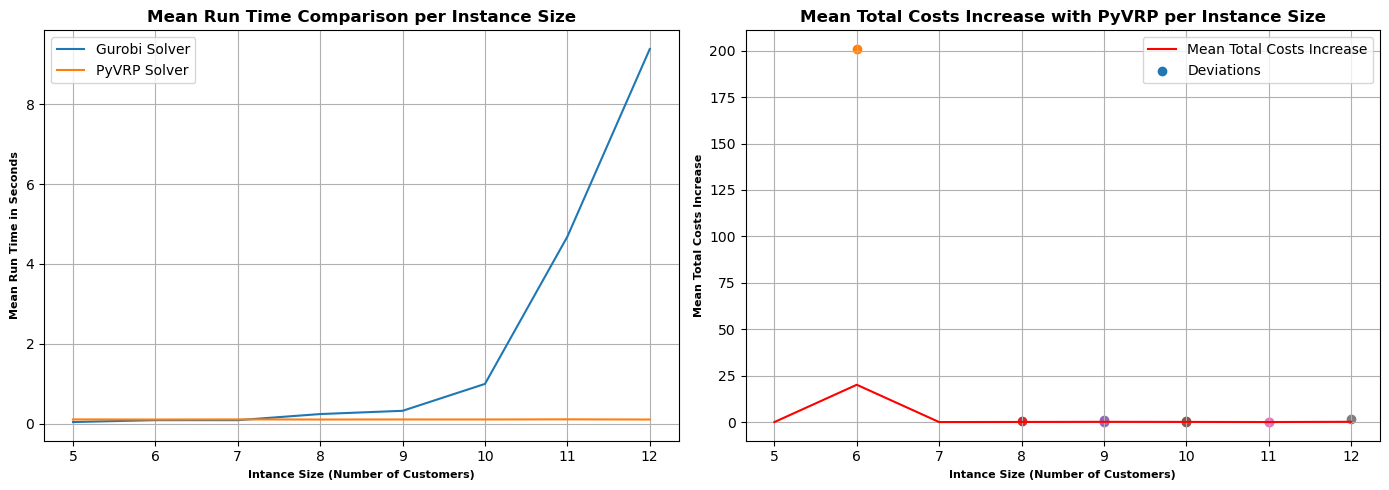

In [ ]:
# Get mean run time of both solvers
mean_runtime_gurobi = np.mean([res_gurobi[key]['Run Times'][0] for key in res_gurobi.keys()])
mean_runtime_PyVRP= np.mean([res_PyVRP[key]['Run Times'][0] for key in res_PyVRP.keys()])
print('Mean Run Time of Gurobi Solver: {} sec \nMean Run Time of PyVRP Solver: {} sec'.format(np.round(mean_runtime_gurobi, 4), np.round(mean_runtime_PyVRP, 4)))

# Get all total costs
total_costs_gurobi = [res_gurobi[key]['Total Costs'] for key in res_gurobi.keys()]
total_costs_PyVRP = [res_PyVRP[key]['Total Costs'] for key in res_PyVRP.keys()]

# Compute the proportion of identical solutions
num_identical_solutions = 0
for index in range(len(num_customers_list)):
    num_identical_solutions += np.sum([i == j for i, j in zip(total_costs_gurobi[index], total_costs_PyVRP[index])])
pct_identical_solutions = np.round(num_identical_solutions / len(iterations), 4) * 100
print('\nProportion of optimal solutions by PyVRP: {} %'.format(pct_identical_solutions))

# Get mean run time for all instance sizes of both solvers
mean_cat_runtime_gurobi = {key: np.round(np.mean(res_gurobi[key]['Run Times']),4) for key in res_gurobi.keys()}
mean_cat_runtime_PyVRP = {key: np.round(np.mean(res_PyVRP[key]['Run Times']), 4) for key in res_PyVRP.keys()}

# Get all total costs per instance size of both solvers
cat_costs_gurobi = {key: res_gurobi[key]['Total Costs'] for key in res_gurobi.keys()}
cat_costs_PyVRP = {key: res_PyVRP[key]['Total Costs'] for key in res_PyVRP.keys()}
cat_costs_differences = {}
deviations = {}

# Compute the deviations of all total costs and the mean per instance size
for key in res_gurobi.keys():
    differences = [cat_costs_PyVRP[key][i] - cat_costs_gurobi[key][i] for i in range(number_of_instances_per_size)]
    cat_costs_differences[key] = np.mean(differences)
    deviations[key] = [i for i in differences if i > 0]

# Create subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# Plot mean run times per instance size
axs[0].plot(mean_cat_runtime_gurobi.values(), label='Gurobi Solver')
axs[0].plot(mean_cat_runtime_PyVRP.values(), label='PyVRP Solver')
axs[0].set_xticks(ticks=range(len(mean_cat_runtime_gurobi.keys())), labels=mean_cat_runtime_gurobi.keys())
axs[0].set_xlabel('Intance Size (Number of Customers)', size=8, fontweight='bold')
axs[0].set_ylabel('Mean Run Time in Seconds', size=8, fontweight='bold')
axs[0].set_title('Mean Run Time Comparison per Instance Size', size=12, fontweight='bold')
axs[0].grid(axis='both')
axs[0].legend()

# Plot mean total costs deviation per instance size
axs[1].plot(cat_costs_differences.keys(), cat_costs_differences.values(), color='r', label='Mean Total Costs Increase')
for key in deviations.keys():
    axs[1].scatter(x=np.repeat(key, len(deviations[key])), y=deviations[key], label='Deviations' if key == list(cat_costs_differences.keys())[0] else "")
axs[1].set_xticks(list(mean_cat_runtime_gurobi.keys()))
axs[1].set_xticklabels(cat_costs_differences.keys())
axs[1].set_xlabel('Intance Size (Number of Customers)', size=8, fontweight='bold')
axs[1].set_ylabel('Mean Total Costs Increase', size=8, fontweight='bold')
axs[1].set_title('Mean Total Costs Increase with PyVRP per Instance Size', size=12, fontweight='bold')
axs[1].grid(axis='both')
axs[1].legend()
plt.tight_layout()
plt.show()

### **View the instances with different solutions by the solvers**

Total costs: 328.6138252569385
Optimal solution: [(0, 3), (1, 14), (2, 7), (3, 9), (4, 2), (5, 8), (6, 5), (7, 11), (8, 1), (9, 12), (10, 0), (11, 6), (12, 4), (13, 10), (14, 13)]


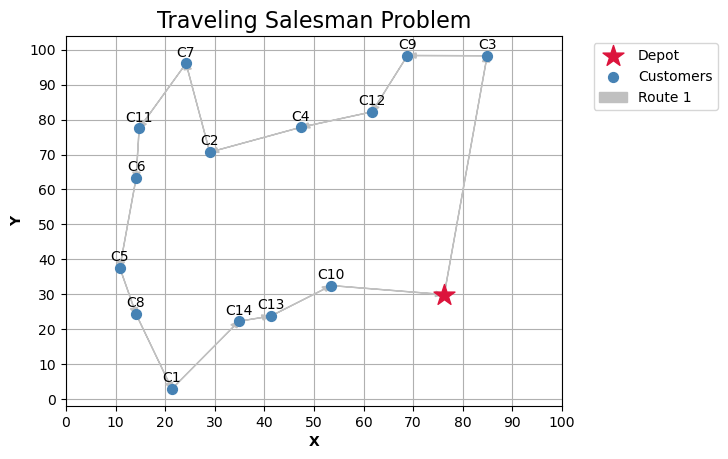

Exact Total costs: 330.6452890941244 and Rounded Total Costs: 326
Optimal solution: [(0, 10), (10, 13), (13, 14), (14, 1), (1, 8), (8, 5), (5, 6), (6, 2), (2, 11), (11, 7), (7, 4), (4, 12), (12, 9), (9, 3), (3, 0)]


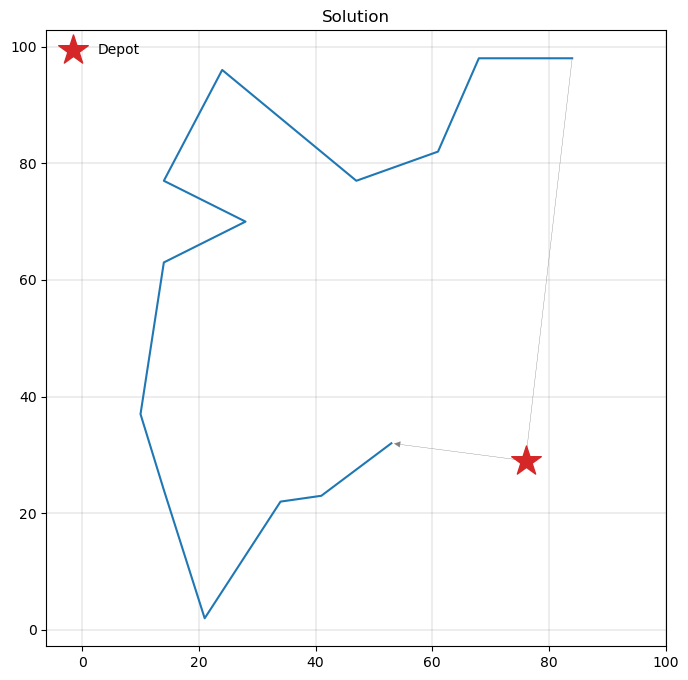

In [27]:
# Define Instance ID in list 'instances'
id = 6
c1 = instances[id]['Total Costs Gurobi']
c2 = instances[id]['Total Costs PyVRP']
print('{} - {} = {}'.format(c1, c2, c2-c1))

# Get instance details
coord = instances[id]['Coordinates']
demands = instances[id]['Demands']
capacity = instances[id]['Capacity']
sequence = instances[id]['Sequence Gurobi']
total_costs = instances[id]['Total Costs Gurobi']

# Solve instance with Gurobi and plot the optimal solution
plot_instance(coord=coord, sequence=sequence, total_costs=total_costs, x_range=x_range, y_range=y_range, 
              assignments=None, core_point_indices=None, plot_sequence=True, print_sequence=True, routing_problem=routing_problem)

# Solve instance with PyVRP and plot the optimal solution
sequence, total_costs = solve_PyVRP(coord, demands=demands, capacity=capacity, max_runtime=1, 
                                    plot_results=True, prints=False)